In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
import matplotlib.pyplot as plt

from datasets import DataMNIST

%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [17]:
# DTYPE = torch.FloatTensor # run on CPU
DTYPE = torch.cuda.FloatTensor # run on GPU

NOISE_DIM = 96

# Dataset

In [3]:
# MNIST dataset
dataloader = DataMNIST('./datasets/mnist_data/')
dataloader.show_info()

Training data shape:  (60000, 1, 28, 28)
Training labels shape:  (60000,)
Validating data shape:  (0, 1, 28, 28)
Validating labels shape:  (0,)
Testing data shape:  (10000, 1, 28, 28)
Testing labels shape:  (10000,)


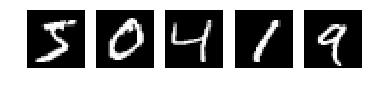

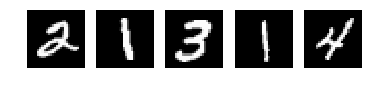

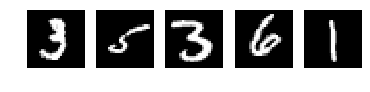

In [4]:
# show some data
x, y = dataloader.get_batch(15)
dataloader.show_by_data(x, y, maxflen=5)

# General functions

In [24]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)
    
class Unflatten(nn.Module):
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

# def initialize_weights(m):
#     if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
#         init.xavier_uniform_(m.weight.data)
    
# sample noise
def sample_noise(batch_size, dim=NOISE_DIM, dtype=DTYPE):
    noise = torch.rand([batch_size, dim]) * 2 - 1
    return noise.type(dtype)

# train GAN
def train_gan(D, G, D_Loss, G_Loss, D_optimer, G_optimer, dataloader, 
              num_ite=4000, dtype=DTYPE):
    # hyperparameters
    batch_size = 128
    
    # prepare
    D = D.type(dtype)
    G = G.type(dtype)
    
    # train
    for t in range(num_ite):
        # train the discriminator
        D_optimer.zero_grad()
        
        data_real, _ = dataloader.get_batch_torch(batch_size, dtype=dtype)
        scores_real = D(data_real)# .type(dtype)
        
        noise = sample_noise(batch_size, dtype=dtype)
        data_fake = G(noise).detach().view(-1, 1, 28, 28)
        scores_fake = D(data_fake)# .type(dtype)
        
        d_loss = D_Loss(scores_real, scores_fake)
        d_loss.backward()
        
        D_optimer.step()
        
        # train the generator
        G_optimer.zero_grad()
        
        noise = sample_noise(batch_size, dtype=dtype)
        data_fake = G(noise).view(-1, 1, 28, 28)
        scores_fake = D(data_fake)# .type(dtype)
        
        g_loss = G_Loss(scores_fake)
        g_loss.backward()
        
        G_optimer.step()
        
        # show training info
        if t == 0 or (t + 1) % 200 == 0:
            print('After {} iteration: D loss {:.5}, G loss {:.5}'.format(t + 1, d_loss.item(), g_loss.item()))
            
        if t == 0 or (t + 1) % 1000 == 0:
            images = data_fake.data.cpu().numpy()
            dataloader.show_by_data(images[0: 10], None, maxflen=5)
    
    # return
    return G

# Vanilla GAN

In [25]:
def discriminator():
    model = nn.Sequential(
        Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(0.01, inplace=True),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.01, inplace=True),
        nn.Linear(256, 1)
    )
    return model

def generator(noise_dim=NOISE_DIM):
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 784),
        nn.Tanh()
    )
    return model

def bce_loss(scores, target):
    """
    Numerically stable version of the binary cross-entropy loss function.
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    """
    neg_abs = - scores.abs()
    loss = scores.clamp(min=0) - scores * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(scores_real, scores_fake):
    N_real = scores_real.shape[0]
    N_fake = scores_fake.shape[0]
    return bce_loss(scores_real, 1) + bce_loss(scores_fake, 0)

def generator_loss(scores_fake):
    N_fake = scores_fake.shape[0]
    return bce_loss(scores_fake, 1)

After 1 iteration: D loss 1.3856, G loss 0.72377


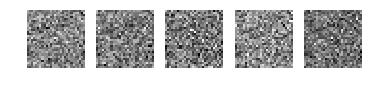

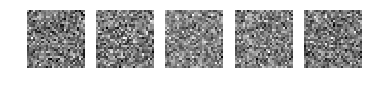

After 200 iteration: D loss 1.31, G loss 0.88888
After 400 iteration: D loss 0.88735, G loss 1.4857
After 600 iteration: D loss 1.3772, G loss 1.0761
After 800 iteration: D loss 1.1921, G loss 0.93548
After 1000 iteration: D loss 1.2645, G loss 1.3113


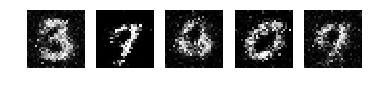

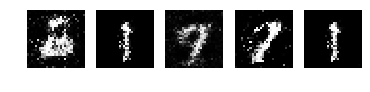

After 1200 iteration: D loss 1.1663, G loss 1.0054
After 1400 iteration: D loss 1.2395, G loss 0.90911
After 1600 iteration: D loss 1.2792, G loss 0.7806
After 1800 iteration: D loss 1.259, G loss 0.9225
After 2000 iteration: D loss 1.3507, G loss 0.87355


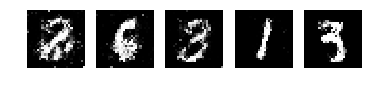

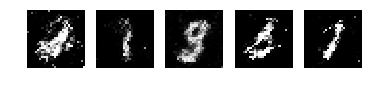

After 2200 iteration: D loss 1.3198, G loss 0.98675
After 2400 iteration: D loss 1.2539, G loss 0.85225
After 2600 iteration: D loss 1.2376, G loss 0.82818
After 2800 iteration: D loss 1.3971, G loss 0.77231
After 3000 iteration: D loss 1.2749, G loss 0.91137


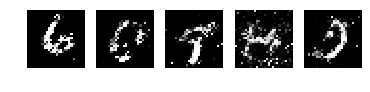

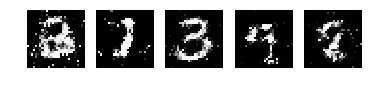

After 3200 iteration: D loss 1.3396, G loss 1.0527
After 3400 iteration: D loss 1.3304, G loss 0.84484
After 3600 iteration: D loss 1.31, G loss 0.70754
After 3800 iteration: D loss 1.3411, G loss 0.84963
After 4000 iteration: D loss 1.289, G loss 0.8104


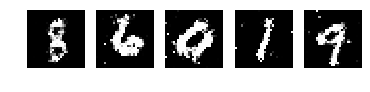

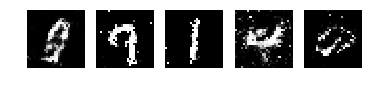

In [26]:
# the models
D = discriminator()
G = generator()

# the losses
D_Loss = discriminator_loss
G_Loss = generator_loss

# the optimers
D_optimer = optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_optimer = optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999))

# train
G_trained = train_gan(D, G, discriminator_loss, generator_loss, 
                      D_optimer, G_optimer, dataloader, num_ite=4000)

# Least Square GAN

In [29]:
def ls_discriminator_loss(scores_real, scores_fake):
    N_real = scores_real.shape[0]
    N_fake = scores_fake.shape[0]
    loss = ((scores_real - 1) ** 2 + scores_fake ** 2) / 2
    return loss.mean()

def ls_generator_loss(scores_fake):
    N_fake = scores_fake.shape[0]
    loss = ((scores_fake - 1) ** 2) / 2
    return loss.mean()

After 1 iteration: D loss 0.47525, G loss 0.46219


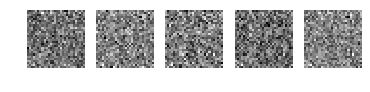

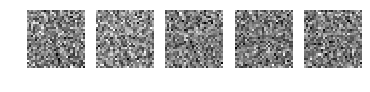

After 200 iteration: D loss 0.16597, G loss 0.31497
After 400 iteration: D loss 0.082019, G loss 0.38981
After 600 iteration: D loss 0.15717, G loss 0.29221
After 800 iteration: D loss 0.15366, G loss 0.30237
After 1000 iteration: D loss 0.12681, G loss 0.30928


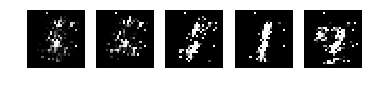

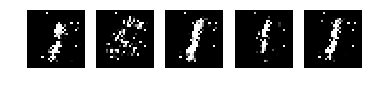

After 1200 iteration: D loss 0.1925, G loss 0.17023
After 1400 iteration: D loss 0.16298, G loss 0.24431
After 1600 iteration: D loss 0.26505, G loss 0.16003
After 1800 iteration: D loss 0.2115, G loss 0.18752
After 2000 iteration: D loss 0.21047, G loss 0.21548


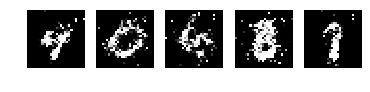

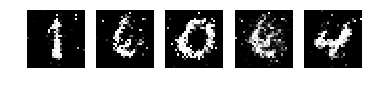

After 2200 iteration: D loss 0.22006, G loss 0.17
After 2400 iteration: D loss 0.22199, G loss 0.20692
After 2600 iteration: D loss 0.25099, G loss 0.14633
After 2800 iteration: D loss 0.22029, G loss 0.16922
After 3000 iteration: D loss 0.23848, G loss 0.19018


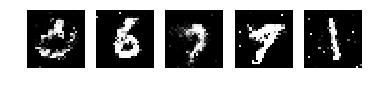

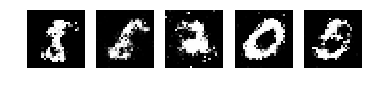

After 3200 iteration: D loss 0.22665, G loss 0.15294
After 3400 iteration: D loss 0.23538, G loss 0.16092
After 3600 iteration: D loss 0.23649, G loss 0.14471
After 3800 iteration: D loss 0.22972, G loss 0.15784
After 4000 iteration: D loss 0.22672, G loss 0.1553


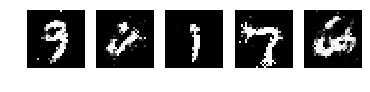

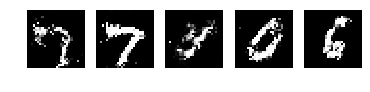

In [30]:
# the models
D_ls = discriminator()
G_ls = generator()

# the optimers
D_ls_optimer = optim.Adam(D_ls.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_ls_optimer = optim.Adam(G_ls.parameters(), lr=1e-3, betas=(0.5, 0.999))

# train
G_ls_trained = train_gan(D_ls, G_ls, ls_discriminator_loss, ls_generator_loss, 
                         D_ls_optimer, G_ls_optimer, dataloader, num_ite=4000)

# Deeply Convolutional GANs

In [31]:
def dc_discriminator():
    model = nn.Sequential(
        Unflatten(-1, 1, 28, 28),
        nn.Conv2d(1, 32, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, stride=1),
        nn.LeakyReLU(0.01, inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        Flatten(),
        nn.Linear(4 * 4 * 64, 4 * 4 * 64),
        nn.LeakyReLU(0.01),
        nn.Linear(4 * 4 * 64, 1)
    )
    return model

def dc_generator(noise_dim=NOISE_DIM):
    model = nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(1024),
        nn.Linear(1024, 7 * 7 * 128),
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(7 * 7 * 128),
        Unflatten(-1, 128, 7, 7),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
        nn.Tanh(),
        Flatten()
    )
    return model

After 1 iteration: D loss 1.3643, G loss 0.92933


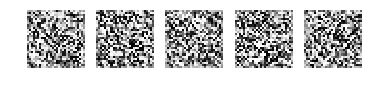

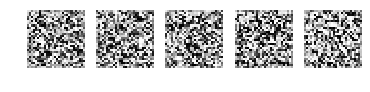

After 200 iteration: D loss 1.2548, G loss 0.93278
After 400 iteration: D loss 1.1309, G loss 1.0785
After 600 iteration: D loss 1.2322, G loss 0.88033
After 800 iteration: D loss 1.1856, G loss 0.83663
After 1000 iteration: D loss 1.1779, G loss 0.91776


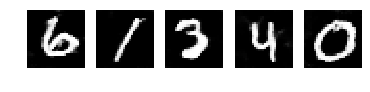

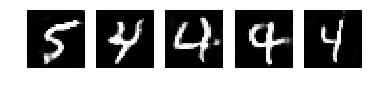

After 1200 iteration: D loss 1.1381, G loss 0.95598
After 1400 iteration: D loss 1.3714, G loss 0.72582
After 1600 iteration: D loss 1.2187, G loss 0.7342
After 1800 iteration: D loss 1.0677, G loss 0.76575
After 2000 iteration: D loss 1.0988, G loss 0.78447


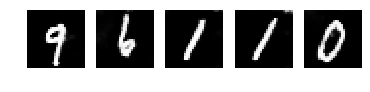

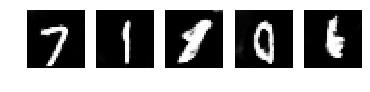

After 2200 iteration: D loss 1.1193, G loss 1.0887
After 2400 iteration: D loss 1.0428, G loss 1.0128
After 2600 iteration: D loss 1.2117, G loss 1.2418
After 2800 iteration: D loss 1.2303, G loss 1.691
After 3000 iteration: D loss 1.4138, G loss 1.1761


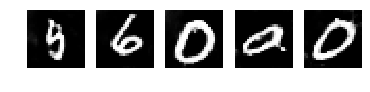

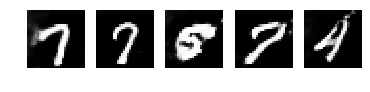

After 3200 iteration: D loss 1.08, G loss 1.2084
After 3400 iteration: D loss 1.0526, G loss 1.1115
After 3600 iteration: D loss 1.0155, G loss 1.3913
After 3800 iteration: D loss 0.97887, G loss 1.4003
After 4000 iteration: D loss 0.87746, G loss 1.262


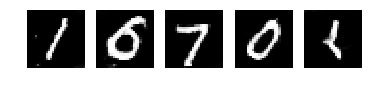

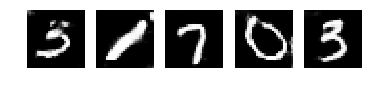

In [32]:
# the models
D_dc = dc_discriminator()
G_dc = dc_generator()

# the optimers
D_dc_optimer = optim.Adam(D_dc.parameters(), lr=1e-3, betas=(0.5, 0.999))
G_dc_optimer = optim.Adam(G_dc.parameters(), lr=1e-3, betas=(0.5, 0.999))

# train
G_LS_trained = train_gan(D_dc, G_dc, discriminator_loss, generator_loss, 
                         D_dc_optimer, G_dc_optimer, dataloader, num_ite=4000)